# Prologue

**Goal**: Given a folder with warnings the goal is to cluster them and generate python programs that can be used to filter out duplicated warnings, so to reduce the effort in manually checking them.

In [1]:
from typing import List, Tuple, Dict, Any, Optional
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import json
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

## Parameters

In [25]:
PATH_ROOT_DIR: str = ".."

INFO_TO_USE_FOR_CLUSTERING: List[str] = [
    'exception_message', 'essential_file_content']


AI_MODEL: str = "llama-3.1-70b-versatile"  # or "gpt-4o-mini"
# AI_MODEL: str = "gpt-4o-mini"
# AI_MODEL: str = "gemma2-9b-it"

N_POSITIVE_EXAMPLES_TO_SHOW_LLM: int = 5
N_NEGATIVE_EXAMPLES_TO_SHOW_LLM: int = 5

# Test run
# DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "v001", "2024_10_04__14_48__qiskit")
# Run with 10k programs: v001.yaml
# program_bank/v001/2024_10_04__15_10__qiskit
# DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "v001", "2024_10_04__15_10__qiskit")
# program_bank/v002/2024_10_07__17_03__qiskit
# program_bank/v008/2024_11_07__15_05__qiskit
DIR_PROGRAM_BANK: str = os.path.join(
    "..", "program_bank", "v008", "2024_11_07__15_05__qiskit")

SAMPLE_SIZE: Optional[int] = None

# VECTORIZATION
VECTORIZATION_METHOD: str = "TFIDF"
# Values: TFIDF, LOCAL_EMBEDDING
EMBEDDING_NAME: str = "dunzhang/stella_en_400M_v5"

# DIMENSIONALITY REDUCTION
USE_PCA: bool = True
PCA_COMPONENTS: int = 3

# CLUSTERING
CLUSTERING_METHOD: str = "DBSCAN"
# Values: KMEANS, DBSCAN

# PROMPT CONTENT
PROMPT_CONTENT: str = "ONLY_ERROR_MESSAGE"
# Values: ONLY_ERROR_MESSAGE, ONLY_FILE_CONTENT, BOTH_ERROR_AND_PROGRAM


CACHE_FOLDER: str = os.path.join("..", ".cache")

In [26]:
# print the current folder
print(f"Current folder: {os.getcwd()}")

all_global_vars = dict(globals().copy())
# print all global variables
for k, v in all_global_vars.items():
    if k.isupper() and len(k) > 1:
        print(f"{k}: {v}")

Current folder: /home/paltenmo/projects/crossplatform/notebooks
PATH_ROOT_DIR: ..
INFO_TO_USE_FOR_CLUSTERING: ['exception_message', 'essential_file_content']
AI_MODEL: llama-3.1-70b-versatile
N_POSITIVE_EXAMPLES_TO_SHOW_LLM: 5
N_NEGATIVE_EXAMPLES_TO_SHOW_LLM: 5
DIR_PROGRAM_BANK: ../program_bank/v008/2024_11_07__15_05__qiskit
SAMPLE_SIZE: None
VECTORIZATION_METHOD: TFIDF
EMBEDDING_NAME: dunzhang/stella_en_400M_v5
USE_PCA: True
PCA_COMPONENTS: 3
CLUSTERING_METHOD: DBSCAN
PROMPT_CONTENT: ONLY_ERROR_MESSAGE
CACHE_FOLDER: ../.cache
PCA: <class 'sklearn.decomposition._pca.PCA'>
DBSCAN: <class 'sklearn.cluster._dbscan.DBSCAN'>
HTML: <class 'IPython.core.display.HTML'>
K_DATAPOINT_PER_CLUSTER: 10


## AI Models

In [27]:
import openai
import groq

path_groq_token = os.path.join(PATH_ROOT_DIR, "groq_token.txt")
groq_token = Path(path_groq_token).read_text().strip()

# Export the GROQ_TOKEN as GROQ_API_KEY
os.environ['GROQ_API_KEY'] = groq_token

path_openai_key = os.path.join(PATH_ROOT_DIR, "openai_token.txt")
openai_key = Path(path_openai_key).read_text().strip()

os.environ['OPENAI_API_KEY'] = openai_key

## Read Error Messages

In [28]:
from multiprocessing import Pool
import re


def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["error_file"] = os.path.basename(file_path)
        return data


def read_all_programs(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(
        dir_path) if re.match(r'.*_error\.json$', f)]
    # sort the files
    json_files.sort()
    records = []

    with Pool() as pool:
        results = pool.map(read_json_file, json_files)
        records.extend(results)

    return pd.DataFrame(records)


# Use the function to read all programs
df_errors_all = read_all_programs(DIR_PROGRAM_BANK)

# augment the dataframe with the proram content


def read_file_content(file_name: str) -> str:
    file_path = os.path.join(DIR_PROGRAM_BANK, file_name)
    with open(file_path, 'r') as file:
        return file.read()


# Use parallel apply to read the file content
with Pool() as pool:
    df_errors_all['file_content'] = pool.map(
        read_file_content, df_errors_all['current_file'])

# Alternatively, you can use apply without parallel processing
# df_errors['file_content'] = df_errors['current_file'].apply(read_file_content)

df_errors_all.head()
n_errors = len(df_errors_all)
print(f"Number of errors: {n_errors}")

Number of errors: 19393


### Optional: Sample Only Some Errors

In [29]:
df_errors = df_errors_all.copy()
if SAMPLE_SIZE and len(df_errors) > SAMPLE_SIZE:
    df_errors = df_errors.sample(SAMPLE_SIZE, random_state=42)
else:
    df_errors = df_errors.copy()  # use all errors
print(f"Number of errors in the sample: {len(df_errors)}")

Number of errors in the sample: 19393


### Preprocessing

In [30]:
# Extract the essential file content between "# <START_GATES>" and "# <END_GATES>"
def extract_essential_content(file_content: str) -> str:
    start_marker = "# <START_GATES>"
    end_marker = "# <END_GATES>"
    start_index = file_content.find(start_marker)
    end_index = file_content.find(end_marker, start_index)
    if start_index != -1 and end_index != -1:
        return file_content[start_index + len(start_marker):end_index].strip()
    return ""

df_errors['essential_file_content'] = df_errors['file_content'].apply(extract_essential_content)
df_errors['to_vectorize'] = df_errors[INFO_TO_USE_FOR_CLUSTERING].apply(
    lambda row: ' '.join(row.values.astype(str)), axis=1)

assert "to_vectorize" in df_errors.columns, "Column 'to_vectorize' not found in the dataframe"

# # Test case to check if the resulting essential_file_content has all lines starting with 'qc.'
# def test_extract_essential_content():
#     if df_errors.empty:
#         print("Dataframe is empty. Skipping the test.")
#         return
#     first_row_content = df_errors['file_content'].iloc[0]
#     essential_content = extract_essential_content(first_row_content)
#     lines = essential_content.split('\n')
#     assert all(line.strip().startswith('qc.') for line in lines), "Not all lines start with 'qc.'"
#     print("Test passed: All lines in the essential content start with 'qc.'")

# # Run the test case
# test_extract_essential_content()

### Helper Functions: Viz and Find-K

In [31]:
import os
import sys
import json
import random
from pathlib import Path
from typing import List, Dict, Tuple, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import csr_matrix, vstack
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sentence_transformers import SentenceTransformer


def stratified_sampling(data, labels, sample_size=100) -> Tuple[np.ndarray, np.ndarray]:
    """Sample data points from each cluster.

    Arguments:
    - data: the data points as csr matrix
    - labels: the cluster labels of the data points [list of int]
    - sample_size: the number of samples to take from each cluster

    Implementation:
    first extract all the X representing data from the same cluster
    (using label information)
    then sample the data points from the cluster
    """
    map_label_to_data = {}
    for label in np.unique(labels):
        # Extract all data points from the same cluster
        X_cluster = data[labels == label]
        # Sample the data points
        if X_cluster.shape[0] > sample_size:
            X_sampled = X_cluster[np.random.choice(
                X_cluster.shape[0], sample_size, replace=False)]
        else:
            X_sampled = X_cluster
        # Store the sampled data points
        map_label_to_data[label] = X_sampled
    # concatenate the sampled data points
    for k, v in map_label_to_data.items():
        print(f'Cluster {k}: {v.shape[0]} data points')

    # concatenate data points from all clusters
    if isinstance(data, csr_matrix):
        X_sampled = vstack([X_cluster
                            for X_cluster in map_label_to_data.values()])
    else:
        X_sampled = np.vstack(
            [X_cluster.toarray()
             if isinstance(X_cluster, csr_matrix) else X_cluster
             for X_cluster in map_label_to_data.values()])
    # create the corresponding labels
    sampled_labels = []
    for label, X_cluster in map_label_to_data.items():
        sampled_labels.extend([label] * X_cluster.shape[0])
    nd_sampled_labels = np.array(sampled_labels)
    assert X_sampled.shape[0] == nd_sampled_labels.shape[0], 'The number of data points and labels should match'
    return X_sampled, nd_sampled_labels

# Test cases


def test_stratified_sampling():

    # Create a small dataset
    data = csr_matrix([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [0, 1, 1],
        [1, 0, 1]
    ])
    labels = np.array([0, 0, 1, 1, 2, 2])

    # Test with sample size less than the number of data points in each cluster
    X_sampled, sampled_labels = stratified_sampling(
        data, labels, sample_size=1)
    assert X_sampled.shape[0] == 3, "Test case 1 failed"
    assert len(np.unique(sampled_labels)) == 3, "Test case 1 failed"

    # Test with sample size more than the number of data points in each cluster
    X_sampled, sampled_labels = stratified_sampling(
        data, labels, sample_size=3)
    assert X_sampled.shape[0] == 6, "Test case 2 failed"
    assert len(np.unique(sampled_labels)) == 3, "Test case 2 failed"

    print("All test cases passed!")

# Run test cases
# test_stratified_sampling()


def find_optimal_k_silhouette(data, k_range: range = range(2, 11)) -> int:
    silhouette_scores = []
    random.seed(42)
    for k in k_range:
        print(f'Running K-Means with K={k}')
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)

        # Sample data points from each cluster
        X_sampled, sampled_labels = stratified_sampling(data, kmeans.labels_)

        # Compute silhouette score on the sampled data
        score = silhouette_score(X_sampled, sampled_labels)
        silhouette_scores.append(score)

    # Find the optimal k with the highest silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.show()
    return optimal_k


def find_optimal_k_knead(
        data, k_range: range = range(2, 11),
        n_reruns: int = 5) -> int:
    """
    Find the optimal number of clusters (k) for K-Means using the elbow method.
    Parameters:
    data (array-like): The input data to cluster.
    k_range (range, optional): The range of k values to evaluate.
                               Defaults to range(2, 11).
    n_reruns (int, optional): The number of reruns for each k value.

    Returns:
    int: The optimal number of clusters (k) determined by the elbow method.
    """

    distortions = []
    for k in k_range:
        print(f'Running K-Means with K={k}')
        # run the k-means n_reruns times and take the average
        distortions_k = []
        for _ in range(n_reruns):
            kmeans = KMeans(
                n_clusters=k, random_state=random.randint(0, 10000))
            kmeans.fit(data)
            distortions_k.append(kmeans.inertia_)
        distortions.append(np.mean(distortions_k))

    # Use KneeLocator to find the optimal k
    knee_locator = KneeLocator(
        k_range, distortions, curve='convex', direction='decreasing')
    optimal_k = knee_locator.elbow

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, distortions, marker='o')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Distortion')
    plt.show()

    return optimal_k


def print_cluster_examples(
        df: pd.DataFrame, focus_on: List[int] = None, n_elements: int = 5,
        cluster_column: str = 'cluster_embeddings', ):
    for cluster in sorted(df[cluster_column].unique()):
        if focus_on and cluster not in focus_on:
            continue
        print(f'Cluster {cluster}:')
        for i, row in df[df[cluster_column] == cluster].head(n_elements).iterrows():
            print(row['exception_message'])
            # print(row['essential_file_content'])
            # print(row['stack_trace'])
            print('---')
        print('=====================')


def plot_cluster_3D(
        cluster_labels: np.ndarray, X_matrix: np.ndarray,
        angles: List[Tuple[int, int]]) -> plt.Figure:
    """Print the data with cluster labels in 3D plot (using PCA).

    Arguments:
    - cluster_labels: the labels of the clusters
    - X_matrix: the data points
    - angles: the angles to rotate the plot

    Returns:
    - the figure object
    """
    # Apply PCA to reduce the dimensionality of the data
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_matrix)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, len(angles), figsize=(
        8 * len(angles), 8), subplot_kw={'projection': '3d'})

    # Plot each cluster with a different color in each subplot
    for ax, angle in zip(axes, angles):
        for cluster in np.unique(cluster_labels):
            idx = cluster_labels == cluster
            ax.scatter(
                X_pca[idx, 0],
                X_pca[idx, 1],
                X_pca[idx, 2],
                label=f'Cluster {cluster}')
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('PCA Component 3')
        ax.set_title(
            f'3D Visualization of Clusters (View {angles.index(angle) + 1})')
        ax.view_init(*angle)
        ax.legend()
    return fig

# Vectorization Strategy

In [32]:
# papermill_description=CREATING_VECTORS
from typing import Optional
import pandas as pd
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from openai import OpenAI
from sklearn.feature_extraction.text import TfidfVectorizer

from hashlib import blake2b
import pickle


class SingletonModel:
    _instance = None

    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super(SingletonModel, cls).__new__(cls)
            cls._instance.model = SentenceTransformer(
                EMBEDDING_NAME, trust_remote_code=True,
                model_kwargs={"torch_dtype": "float16"}).cuda()
        return cls._instance


def get_fingerprint(df: pd.DataFrame) -> str:
    """Compute the hash of the current_file folder sorted."""
    df = df.copy()
    df.sort_values(by='current_file', inplace=True)
    return blake2b(
        str(df['current_file'].values).encode()).hexdigest()[:6]


def encode_text_w_embeddings(df: pd.DataFrame, embedding_name: str,
                             save_as_csv: Optional[bool] = False,
                             output_column: str = "vectorized_representation",
                             cache_folder: str = ".cache") -> pd.DataFrame:
    df = df.copy()
    fingerprint_start = get_fingerprint(df)
    n_records = len(df)
    embedding_name_for_file = embedding_name.replace("/", "_")
    print(f"Encoding {n_records} records using {embedding_name}...")
    output_file_name: str = os.path.join(
        cache_folder,
        f"{n_records}_errors_embed_{embedding_name_for_file}_{fingerprint_start}.pkl")

    # if the file exists in the cache folder, load it
    if os.path.exists(output_file_name):
        df = pd.read_pickle(output_file_name)
        print(f"Data loaded from {output_file_name}")
        fingerprint_end = get_fingerprint(df)
        assert fingerprint_start == fingerprint_end, "Fingerprint mismatch! (cache might have hit the wrong df)"
        return df

    if embedding_name == "text-embedding-3-small":

        client = OpenAI()

        def get_embedding(text, model="text-embedding-3-small"):
            return client.embeddings.create(
                input=[text],
                model=model).data[0].embedding

        df[output_column] = df["to_vectorize"].apply(
            lambda x: get_embedding(x, model='text-embedding-3-small'))
    else:

        singleton_model = SingletonModel()
        model = singleton_model.model
        model = SentenceTransformer(
            embedding_name, trust_remote_code=True,
            model_kwargs={"torch_dtype": "float16"}).cuda()
        df[output_column] = df["to_vectorize"].progress_apply(
            lambda x: model.encode(x))

    if save_as_csv:
        df.to_pickle(output_file_name)
        print(f"Data saved to {output_file_name}")

    print("Data encoded successfully!")
    print(df[output_column].shape)
    return df


def encode_text_w_tfidf(
        df: pd.DataFrame, save_as_csv: Optional[bool] = False,
        output_column: str = "vectorized_representation",
        cache_folder: str = ".cache") -> pd.DataFrame:
    df = df.copy()
    fingerprint_start = get_fingerprint(df)
    combined_text = df["to_vectorize"]
    output_file_name: str = os.path.join(
        cache_folder, f"{len(df)}_errors_tfidf_{fingerprint_start}.pkl")

    # if the file exists in the cache folder, load it
    if os.path.exists(output_file_name):
        df = pd.read_pickle(output_file_name)
        print(f"Data loaded from {output_file_name}")
        fingerprint_end = get_fingerprint(df)
        assert fingerprint_start == fingerprint_end, "Fingerprint mismatch! (cache might have hit the wrong df)"
        return df

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(combined_text)
    df[output_column] = list(X.toarray())

    if save_as_csv:
        df.to_pickle(output_file_name)
        print(f"Data saved to {output_file_name}")

    print("Data encoded successfully!")
    print(df[output_column].shape)
    return df


if VECTORIZATION_METHOD == "TFIDF":
    df_errors = encode_text_w_tfidf(
        df_errors, save_as_csv=True, cache_folder=CACHE_FOLDER)
elif VECTORIZATION_METHOD == "LOCAL_EMBEDDING":
    df_errors = encode_text_w_embeddings(
        df_errors, embedding_name=EMBEDDING_NAME, save_as_csv=True,
        cache_folder=CACHE_FOLDER)

Data saved to ../.cache/19393_errors_tfidf_894a4f.pkl
Data encoded successfully!
(19393,)


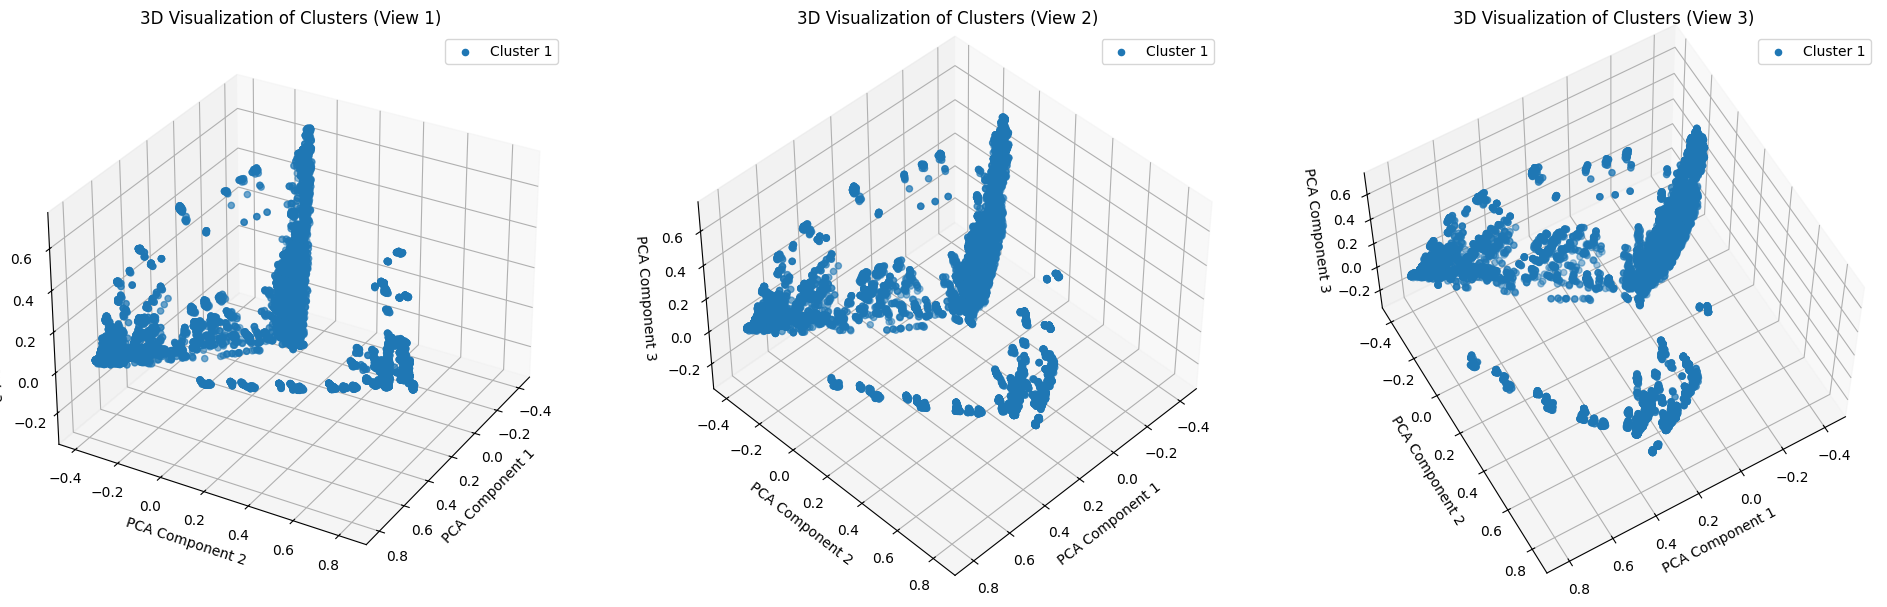

In [33]:
fig = plot_cluster_3D(
    cluster_labels=np.ones(len(df_errors), dtype=int),
    X_matrix=np.array(df_errors['vectorized_representation'].tolist()),
    angles=[(30, 30), (45, 45), (60, 60)])

# Dimensionality Reduction

In [34]:
# Convert the column to a NumPy matrix
X_matrix = np.array(df_errors["vectorized_representation"].tolist())

# Print the matrix
print(X_matrix)

if USE_PCA:
    # Ensure X_matrix is 2D
    if X_matrix.ndim == 1:
        X_matrix = X_matrix.reshape(-1, 1)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=PCA_COMPONENTS)
    X_reduced = pca.fit_transform(X_matrix)
    print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
    X_matrix = X_reduced
    # add new column
    df_errors['vectorized_representation_pca'] = list(X_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Explained variance ratio: [0.14408142 0.09109793 0.04815446]


# Clustering Strategy

X_matrix shape: (19393, 3)
Percentage of noise points removed: 0.10%
Cluster 0:
"<input>:6,5: 'c' is already defined"
---
Classical register redeclared: c.
---
Cluster 1:
Classical register redeclared: c.
---
"<input>:6,5: 'c' is already defined"
---
Cluster 2:
Could not import first circuit: <input>:5:1:
Identifier 'c' already declared.
---
Operation MidMeasureMP not supported by the QASM serializer
---
Cluster 3:
Could not import first circuit: <input>:6:1:
Identifier 'c' already declared.
---
"<input>:6,5: 'c' is already defined"
---
Cluster 4:
Could not import first circuit: <input>:5:1:
Identifier 'c' already declared.
---
Could not import first circuit: <input>:5:1:
Identifier 'c' already declared.
---
Cluster 5:
Could not import first circuit: <input>:5:1:
Identifier 'c' already declared.
---
"<input>:5,5: 'c' is already defined"
---
Cluster 6:
Operation MidMeasureMP not supported by the QASM serializer
---
Classical register redeclared: c.
---
Cluster 7:
"<input>:12,0: 'ryy' is

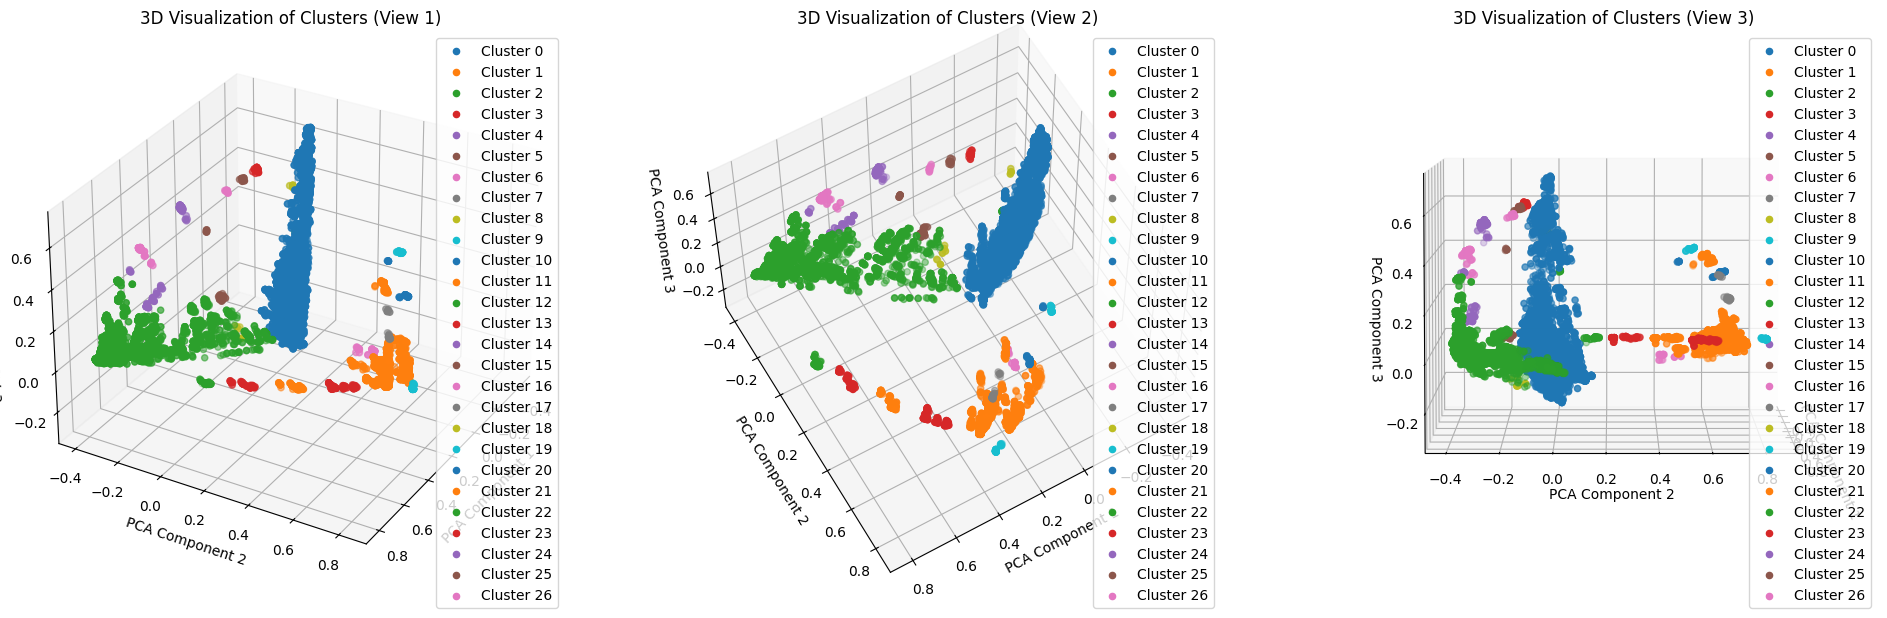

In [35]:
# papermill_description=CLUSTERING

if USE_PCA:
    column_to_cluster = 'vectorized_representation_pca'
else:
    column_to_cluster = 'vectorized_representation'


def apply_kmeans_clustering(
        df: pd.DataFrame, column_to_cluster: str) -> pd.DataFrame:
    X_matrix = np.array(df[column_to_cluster].tolist())
    print(f'X_matrix shape: {X_matrix.shape}')

    print("Finding optimal K using elbow method...")
    optimal_k = find_optimal_k_knead(X_matrix)
    print(f'Optimal K (knead): {optimal_k}')

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(X_matrix)
    labels = kmeans.labels_
    df['cluster_label'] = labels

    return df


def apply_dbscan_clustering(
        df: pd.DataFrame, column_to_cluster: str) -> pd.DataFrame:
    X_matrix = np.array(df[column_to_cluster].tolist())
    print(f'X_matrix shape: {X_matrix.shape}')

    dbscan = DBSCAN(eps=0.05, min_samples=5)
    dbscan.fit(X_matrix)
    labels = dbscan.labels_
    df['cluster_label'] = labels

    # count data with -1 label
    noise_points = len(labels[labels == -1])
    if noise_points == len(labels):
        raise Exception(
            "All data points are considered noise by DBSCAN. "
            "Please adjust the hyperparameters.")

    # ignore the noise points
    original_count = len(df)
    df = df[labels != -1]
    new_count = len(df)
    percentage_removed = ((original_count - new_count) / original_count) * 100
    print(f"Percentage of noise points removed: {percentage_removed:.2f}%")

    return df


# Apply the appropriate clustering method
if CLUSTERING_METHOD == "KMEANS":
    df_errors = apply_kmeans_clustering(df_errors, column_to_cluster)
elif CLUSTERING_METHOD == "DBSCAN":
    df_errors = apply_dbscan_clustering(df_errors, column_to_cluster)

print_cluster_examples(
    df_errors,
    cluster_column='cluster_label',
    n_elements=2)

fig = plot_cluster_3D(
    cluster_labels=df_errors['cluster_label'],
    X_matrix=np.array(df_errors[column_to_cluster].tolist()),
    angles=[(30, 30), (60, 60), (5, 0)])

## Further Inspection

In [22]:
from IPython.display import display, HTML

K_DATAPOINT_PER_CLUSTER = 10


def display_error_messages(df: pd.DataFrame, dir_program_bank: str,
                           cluster_column: str = 'cluster'):
    # Derive the number of clusters from the unique values in the 'cluster' column
    n_clusters = df[cluster_column].nunique()

    # Print K error messages for each cluster
    for cluster in range(n_clusters):
        print(f"\nCluster {cluster}:\n")
        cluster_messages = df[df[cluster_column] == cluster][[
            'exception_message', 'current_file', 'error_file']].head(
            K_DATAPOINT_PER_CLUSTER)
        for _, row in cluster_messages.iterrows():
            file_path = os.path.join(dir_program_bank, row['current_file'])
            error_file_path = os.path.join(dir_program_bank, row['error_file'])
            print(f"Message: {row['exception_message']}")
            link = f'<a href="{file_path}" target="_blank">File</a>'
            error_link = f'<a href="{error_file_path}" target="_blank">Error File</a>'

            # print a command of this kind
            # python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/2024_09_25__15_12__qiskit --path_to_error program_bank/2024_09_25__15_12__qiskit/qiskit_circuit_5q_10g_1_56f829_43fca2_error.json --clue_message "'rxx' is not defined in this scope"
            # remove the "../" from the start
            dir_program_bank_repo_root = dir_program_bank[len(
                f"{PATH_ROOT_DIR}/"):]
            path_to_error_repo_root = error_file_path[len(
                f"{PATH_ROOT_DIR}/"):]
            command = f"python -m analysis_and_reporting.ddmin_target_file --input_folder {dir_program_bank_repo_root} --path_to_error {path_to_error_repo_root} --clue_message '{row['exception_message']}'"
            # escape all the quotes
            print(f"Command: {command}")
            command = command.replace("'", "\\'")
            command = command.replace('"', '\\"')

            button_html = f"""
            <button onclick="navigator.clipboard.writeText('{command}')">Copy Command</button>
            """
            display(HTML(link + " | " + error_link + " | " + button_html))


# Example usage
display_error_messages(df_errors,
                       dir_program_bank=DIR_PROGRAM_BANK,
                       cluster_column='cluster_label')


Cluster 0:

Message: "<input>:5,5: 'c' is already defined"
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v008/2024_11_07__15_05__qiskit --path_to_error program_bank/v008/2024_11_07__15_05__qiskit/qiskit_circuit_5q_10g_7574_13c3bc_4a6193_error.json --clue_message '"<input>:5,5: 'c' is already defined"'


Message: Classical register redeclared: c.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v008/2024_11_07__15_05__qiskit --path_to_error program_bank/v008/2024_11_07__15_05__qiskit/qiskit_circuit_5q_10g_6138_51b0ce_aee3d0_error.json --clue_message 'Classical register redeclared: c.'


Message: "<input>:5,5: 'c' is already defined"
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v008/2024_11_07__15_05__qiskit --path_to_error program_bank/v008/2024_11_07__15_05__qiskit/qiskit_circuit_5q_10g_1346_3102b4_7e8652_error.json --clue_message '"<input>:5,5: 'c' is already defined"'


Message: Classical register redeclared: c.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v008/2024_11_07__15_05__qiskit --path_to_error program_bank/v008/2024_11_07__15_05__qiskit/qiskit_circuit_5q_10g_6511_558812_e34a7d_error.json --clue_message 'Classical register redeclared: c.'


Message: Operation MidMeasureMP not supported by the QASM serializer
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v008/2024_11_07__15_05__qiskit --path_to_error program_bank/v008/2024_11_07__15_05__qiskit/qiskit_circuit_5q_10g_6739_8709f7_4e59af_error.json --clue_message 'Operation MidMeasureMP not supported by the QASM serializer'


Message: Operation MidMeasureMP not supported by the QASM serializer
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v008/2024_11_07__15_05__qiskit --path_to_error program_bank/v008/2024_11_07__15_05__qiskit/qiskit_circuit_5q_10g_9853_b28cdd_d00e75_error.json --clue_message 'Operation MidMeasureMP not supported by the QASM serializer'


Message: Classical register redeclared: c.
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v008/2024_11_07__15_05__qiskit --path_to_error program_bank/v008/2024_11_07__15_05__qiskit/qiskit_circuit_5q_10g_5396_88cc6e_a7c542_error.json --clue_message 'Classical register redeclared: c.'


Message: DD for gatemeasure not available!
Command: python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/v008/2024_11_07__15_05__qiskit --path_to_error program_bank/v008/2024_11_07__15_05__qiskit/qiskit_circuit_5q_10g_7637_911f83_59b030_error.json --clue_message 'DD for gatemeasure not available!'


# Generate Detector with LLM

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from typing import List


def diversity_sampling(df: pd.DataFrame, n_samples: int,
                       columns:
                       List[str] = ["exception_message",
                                    "essential_file_content"]) -> pd.DataFrame:
    """Combine the columns into a single text column and sample diverse error messages."""
    print(
        f"Sampling {n_samples} diverse error messages from the dataset with {df.shape[0]} error messages.")

    # Combine the specified columns into a single text column
    df['combined_text'] = df[columns].apply(
        lambda row: ' '.join(row.values.astype(str)), axis=1)

    # Convert the text data into TF-IDF features
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['combined_text'])

    # Reduce dimensionality using PCA
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(tfidf_matrix.toarray())

    # Cluster the data using KMeans
    kmeans = KMeans(n_clusters=n_samples, random_state=42)
    df['cluster'] = kmeans.fit_predict(reduced_features)

    # Sample one data point from each cluster
    sampled_df = df.groupby('cluster').apply(
        lambda x: x.sample(1)).reset_index(
        drop=True)

    return sampled_df

## Prompt: Program Synthesis

In [15]:
PROGRAM_SYNTHESIS_PROMPT = """

By running a fuzzing campaign on compilers, we collected a set of {{ k_errors_to_match }} programs that resulted in different error messages when compiled.
The errors are from the same cluster (using k-means).
Your task is to generate a Python program (based on regex) that can match these errors or programs.

Each error has an exception message and a file content associated with it.
You might be given only the exception message, the file content, or both.

# Errors to match
The errors are as follows:
{% for error in data_k_errors_to_match %}
```plaintext
## Error message
{{ error["message"] }}

## File content
{{ error["file_content"] }}
```
{% endfor %}

Generate only a python program that can match all the errors/file contents, the program is
a single function:

```python
def recognize_error(error_message: str, file_content: str) -> bool:
    pass
```

{% if show_negative_data %}

# Errors that should not be matched
These errors should not be matched by the program (the program should return False for these errors):

{% for error in data_y_errors_to_avoid %}
```plaintext
## Error message
{{ error["message"] }}

## File content
{{ error["file_content"] }}
```
{% endfor %}

{% endif %}

Remember that these functions do not return a boolean value directly.
- .search() returns a match object if there is a match, None otherwise.
- .match() returns a match object if the match is at the beginning of the string, None otherwise.
- .findall() returns a list of all matches in the string.
- be mindful of the new line characters in the file content and error messages
- remember to follow the Python regex syntax
- use regex flags like re.MULTILINE, re.IGNORECASE, etc. if needed
- if the content of the file is not needed to discern, you can set a match only based on the error message
- if the error message is not needed to discern, you can set a match only based on the file content


First elaborate step by step what would the recognize_error look for in the error message and/or the file content.
Then return the single function that can match all the errors in the ```python tags.
Return true if the same error pattern (describe above) is present in the error message and the file content.
Nothing else.
    """

In [16]:
"""This script generates a prompt for the LLM where k errors are shown and the model has to generate a program that can match the errors.
"""

from jinja2 import Template


def create_llm_query_for_error_recognizer(
        df: pd.DataFrame, k_errors_to_match: int, y_errors_to_avoid: int,
        target_cluster: int, prompt_type: str = "BOTH",
        cluster_column: str = "cluster") -> str:
    """
    Create a prompt for the LLM to generate a Python program that can match the given errors.

    Args:
    df (pd.DataFrame): The dataframe containing error data.
    k_errors_to_match (int): The number of errors to sample.
    y_errors_to_avoid (int): The number of errors to avoid.
    target_cluster (int): The target cluster to sample errors from.
    prompt_type (str): The type of prompt to generate.
        "ONLY_FILE_CONTENT": Include in the prompt only the file content
        "ONLY_ERROR_MESSAGE": Include in the prompt only the error message
        "BOTH": Include in the prompt both the file content and the error message
    cluster_column (str): The column name for clusters in the dataframe.

    Returns:
    str: The generated prompt.
    """
    global PROGRAM_SYNTHESIS_PROMPT
    prompt = PROGRAM_SYNTHESIS_PROMPT
    template = Template(prompt)

    df_cluster = df[df[cluster_column] == target_cluster]
    df_rest = df[df[cluster_column] != target_cluster]

    n_data_in_cluster = df_cluster.shape[0]

    if k_errors_to_match == 0:
        raise ValueError(f"No errors found in cluster {target_cluster}")
    if n_data_in_cluster <= k_errors_to_match:
        df_k_samples = df_cluster.copy()
    else:
        df_k_samples = diversity_sampling(
            df_cluster, n_samples=k_errors_to_match,
            columns=['exception_message'])

    if y_errors_to_avoid == 0:
        df_y_samples = pd.DataFrame()
    elif df_rest.shape[0] <= y_errors_to_avoid:
        df_y_samples = df_rest.copy()
    else:
        df_y_samples = diversity_sampling(
            df_rest, n_samples=y_errors_to_avoid,
            columns=['exception_message'])

    # Prepare the error messages
    data_k_errors_to_match = []
    not_provided_message = "Not provided to you in this prompt. Assume that your function received None for this argument."
    for _, row in df_k_samples.iterrows():
        if prompt_type == "ONLY_FILE_CONTENT":
            error_message = not_provided_message
        else:
            error_message = row['exception_message']
        if prompt_type == "ONLY_ERROR_MESSAGE":
            file_content = not_provided_message
        else:
            file_content = row['essential_file_content']
        data_k_errors_to_match.append({
            'message': error_message,
            'file_content': file_content
        })

    data_y_errors_to_avoid = []
    for _, row in df_y_samples.iterrows():
        if prompt_type == "ONLY_FILE_CONTENT":
            error_message = not_provided_message
        else:
            error_message = row['exception_message']
        if prompt_type == "ONLY_ERROR_MESSAGE":
            file_content = not_provided_message
        else:
            file_content = row['essential_file_content']
        data_y_errors_to_avoid.append({
            'message': error_message,
            'file_content': file_content
        })

    # Render the template
    rendered = template.render(
        k_errors_to_match=k_errors_to_match,
        data_k_errors_to_match=data_k_errors_to_match,
        data_y_errors_to_avoid=data_y_errors_to_avoid,
        show_negative_data=y_errors_to_avoid > 0)

    return rendered

In [17]:
from groq import Groq
from functools import lru_cache


@lru_cache(maxsize=None)
def query_model(prompt: str, model_id: str = "llama-3.1-70b-versatile") -> str:
    """
    Query the language model with the given prompt.

    Args:
    prompt (str): The prompt to query the language model.

    Returns:
    str: The response from the language model.
    """
    system_message = "You are a Python programmer trying to generate a program that can match the given errors."
    if model_id == "gpt-4o-mini":
        from openai import OpenAI
        client = OpenAI()
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": prompt},
            ],
        )
        return completion.choices[0].message.content
    client = Groq()
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama-3.1-70b-versatile",
    )
    return chat_completion.choices[0].message.content


def extract_py_code(
        response: str, start_tags: List[str] = ["```", "```python", "```Python"],
        end_tag: str = "```") -> str:
    """
    Extract the Python code from the response of the language model.

    Args:
    response (str): The response from the language model.
    start_tags (List[str]): The list of starting tags to look for.
    end_tag (str): The ending tag to look for.

    Returns:
    str: The extracted Python code from the response.
    """
    # sort tags by length in descending order
    start_tags.sort(key=len, reverse=True)

    start_idx = -1
    for start_tag in start_tags:
        start_idx = response.find(start_tag)
        if start_idx != -1:
            break

    if start_idx == -1:
        return None

    end_idx = response.find(end_tag, start_idx + len(start_tag))
    if end_idx == -1:
        return None

    return response[start_idx + len(start_tag):end_idx].strip()

In [18]:
def evaluate_matching_metrics(df_test_data: pd.DataFrame, sample_size: int = 3,
                              df_rest: pd.DataFrame = None) -> Dict[str, float]:
    """
    Evaluate the matching metrics and print the results.

    Args:
    df_test_data (pd.DataFrame): The dataframe containing test data with 'matched' column.
    sample_size (int): The number of unmatched errors to sample and print. Default is 15.
    """
    report = {}

    # Calculate the percentage of matched errors
    matched_percentage = df_test_data['matched'].mean() * 100
    print(
        colored(
            f"Percentage of matched errors: {matched_percentage:.2f}% (higher is better)",
            'cyan'))
    report['perc_positive_examples_matched'] = matched_percentage

    # Print some unmatched errors
    sample_size = min(
        sample_size, df_test_data[~df_test_data['matched']].shape[0])
    df_unmatched = df_test_data[~df_test_data['matched']].sample(
        sample_size, random_state=42)
    for _, row in df_unmatched.iterrows():
        print(colored("-" * 80, 'red'))
        print(colored(f"Examples of unmatched errors:", 'red'))
        print(colored(f"Error message: {row['exception_message']}", 'red'))
        print(colored(f"File content: {row['essential_file_content']}", 'red'))
        print(colored("-" * 80, 'red'))
    if sample_size == 0:
        print(colored("All errors matched successfully!", 'green'))

    if df_rest is not None:
        # Calculate the percentage of df_rest that is matched
        matched_percentage_complement = df_rest['matched'].mean() * 100
        print(
            colored(
                f"Percentage of matched errors (on complement): {matched_percentage_complement:.2f}% (lower is better)",
                'red'))
        report['perc_negative_examples_matched'] = matched_percentage_complement

    return report

## Dry Run

In [19]:
from termcolor import colored

# Example usage
target_cluster = 0
rendered = create_llm_query_for_error_recognizer(
    df=df_errors,
    k_errors_to_match=N_POSITIVE_EXAMPLES_TO_SHOW_LLM,
    y_errors_to_avoid=N_NEGATIVE_EXAMPLES_TO_SHOW_LLM,
    target_cluster=target_cluster,
    prompt_type=PROMPT_CONTENT,
    cluster_column='cluster_label')

print("=== Prompt ===")
print(rendered)
print("==============")

# Query the language model with the generated prompt
response = query_model(rendered, model_id=AI_MODEL)
print("=== Response ===")
print(response)
print("===============")

# Extract the Python code from the response
py_code = extract_py_code(response)
print("=== Extracted Python Code ===")
print(py_code)
print("==============================")

try:
    # Execute pycode and match
    print("Executing the generated Python code")
    print(colored(py_code, 'magenta'))
    exec(py_code)

    # check how many of the rows are matched by the function

    df_test_data = df_errors.copy()

    # focus on target cluster
    df_test_data = df_test_data[df_test_data['cluster_label'] ==
                                target_cluster]

    df_test_data['matched'] = df_test_data.apply(lambda row: recognize_error(
        row['exception_message'], row['essential_file_content']), axis=1)

    # Example usage
    evaluate_matching_metrics(df_test_data)
except Exception as e:
    print(colored(f"Error: {e}", 'red'))

Sampling 5 diverse error messages from the dataset with 59 error messages.


/tmp/ipykernel_1164328/728420354.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_text'] = df[columns].apply(
/tmp/ipykernel_1164328/728420354.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(reduced_features)
/tmp/ipykernel_1164328/728420354.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either p

Sampling 5 diverse error messages from the dataset with 20 error messages.
=== Prompt ===


By running a fuzzing campaign on compilers, we collected a set of 5 programs that resulted in different error messages when compiled.
The errors are from the same cluster (using k-means).
Your task is to generate a Python program (based on regex) that can match these errors or programs.

Each error has an exception message and a file content associated with it.
You might be given only the exception message, the file content, or both.

# Errors to match
The errors are as follows:

```plaintext
## Error message
The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_5049_4e419d_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_5049_4e419d_qc_qiskit.qasm

## File content
Not provided to you in this prompt. Assume that your function received None for this argument.
```

```plaintext
## Error message
The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_6444_481b07_qc_pytke

## Progam Generation

In [20]:
# papermill_description=PROGRAM_GENERATION
import warnings
import pandas as pd
from termcolor import colored

cluster_column = 'cluster_label'

# Suppress pandas warnings about chained assignments
pd.options.mode.chained_assignment = None

# Suppress FutureWarning and DeprecationWarning, ConvergenceWarning from pandas
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


def evaluate_clusters(df: pd.DataFrame, cluster_column: str) -> Dict[int,
                                                                     Dict[str, float]]:
    """
    Evaluate the clusters in the dataframe and return the results.

    Args:
    df (pd.DataFrame): The dataframe containing the data.
    cluster_column (str): The column name for clusters in the dataframe.

    Returns:
    Dict[int, Dict[str, float]]: A dictionary with cluster numbers as keys and evaluation metrics as values.
    """
    n_clusters = df[cluster_column].nunique()
    print("Clusters: ", df[cluster_column].unique())

    matched_percentage = {}
    matched_percentage_complement = {}
    matched_abs_number = {}
    code_recognizer = {}

    results = {}

    for cluster in tqdm(range(n_clusters), desc="Evaluating clusters"):
        print(f"\nEvaluating cluster {cluster}:\n")
        df_cluster = df[df[cluster_column] == cluster]
        df_test_data = df_cluster.copy()
        # get prompt for LLM to get function recognize_error
        rendered = create_llm_query_for_error_recognizer(
            df=df,
            k_errors_to_match=N_POSITIVE_EXAMPLES_TO_SHOW_LLM,
            y_errors_to_avoid=N_NEGATIVE_EXAMPLES_TO_SHOW_LLM,
            target_cluster=cluster,
            prompt_type=PROMPT_CONTENT,
            cluster_column=cluster_column)
        print(colored("=== Prompt ===", "blue"))
        print(colored(rendered, "blue"))
        response = query_model(rendered, model_id=AI_MODEL)
        py_code = extract_py_code(response)
        print(colored("=== Extracted Python Code ===", "magenta"))
        print(colored(py_code, "magenta"))
        # lack of report
        report_when_errors = {
            'perc_positive_examples_matched': -1,
            'perc_negative_examples_matched': -1,
            'py_code': py_code
        }
        results[cluster] = report_when_errors
        # check that the code can be parsed into valid python code
        try:
            import ast
            ast.parse(py_code)
        except Exception as e:
            print(
                colored(
                    f"Error in compiling the generated code: {e}", "red"))
            code_recognizer[cluster] = None
            continue
        try:
            exec(py_code)
            # simple test call
            assert recognize_error("Error message", "File content") in [
                True, False], "The function should return a boolean value when given strings"
            code_recognizer[cluster] = py_code
            # check how many of the rows are matched by the function
            df_test_data['matched'] = df_test_data.apply(lambda row: bool(recognize_error(
                row['exception_message'], row['essential_file_content'])), axis=1)
            # cast it to boolean
            df_test_data['matched'] = df_test_data['matched'].astype(bool)
        except Exception as e:
            print(
                colored(
                    f"Error in executing the generated code: {e}", "red"))
            code_recognizer[cluster] = None
            continue

        # compute complement
        df_rest = df[df[cluster_column] != cluster]
        df_rest['matched'] = df_rest.apply(lambda row: recognize_error(
            row['exception_message'], row['essential_file_content']), axis=1)
        # cast it to boolean
        df_rest['matched'] = df_rest['matched'].astype(bool)
        # evaluate the matching metrics
        report = evaluate_matching_metrics(df_test_data, df_rest=df_rest)
        report['py_code'] = py_code

        results[cluster] = report

    return results


# Example usage
results = evaluate_clusters(
    df_errors, cluster_column='cluster_label')

Clusters:  [1 0 2]


Evaluating clusters:   0%|          | 0/3 [00:00<?, ?it/s]


Evaluating cluster 0:

Sampling 5 diverse error messages from the dataset with 59 error messages.
Sampling 5 diverse error messages from the dataset with 20 error messages.
=== Prompt ===


By running a fuzzing campaign on compilers, we collected a set of 5 programs that resulted in different error messages when compiled.
The errors are from the same cluster (using k-means).
Your task is to generate a Python program (based on regex) that can match these errors or programs.

Each error has an exception message and a file content associated with it.
You might be given only the exception message, the file content, or both.

# Errors to match
The errors are as follows:

```plaintext
## Error message
The circuits are not equivalent: /workspace/qiskit_circuit_30q_10g_7736_77a209_qc_pennylane.qasm, /workspace/qiskit_circuit_30q_10g_7736_77a209_qc_pytket.qasm

## File content
Not provided to you in this prompt. Assume that your function received None for this argument.
```

```plaintext
## Er

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


=== Prompt ===


By running a fuzzing campaign on compilers, we collected a set of 5 programs that resulted in different error messages when compiled.
The errors are from the same cluster (using k-means).
Your task is to generate a Python program (based on regex) that can match these errors or programs.

Each error has an exception message and a file content associated with it.
You might be given only the exception message, the file content, or both.

# Errors to match
The errors are as follows:

```plaintext
## Error message
Could not import second circuit: <input>:4:6:
Expected 'Identifier', got 'ms'.

## File content
Not provided to you in this prompt. Assume that your function received None for this argument.
```


Generate only a python program that can match all the errors/file contents, the program is
a single function:

```python
def recognize_error(error_message: str, file_content: str) -> bool:
    pass
```



# Errors that should not be matched
These errors should not be mat

In [21]:
results

{0: {'perc_positive_examples_matched': 100.0,
  'perc_negative_examples_matched': 0.0,
  'py_code': 'import re\n\ndef recognize_error(error_message: str, file_content: str) -> bool:\n    """\n    Recognize if the error message matches the identified pattern.\n\n    Args:\n    error_message (str): The error message to be checked.\n    file_content (str): The file content (not used in this implementation).\n\n    Returns:\n    bool: True if the error message matches the pattern, False otherwise.\n    """\n    \n    # Create a regex pattern to match the error message\n    pattern = r"The circuits are not equivalent: .+\\.qasm, .+\\.qasm"\n    \n    # Use re.search to match the pattern\n    if re.search(pattern, error_message):\n        return True\n    \n    # If no match is found, return False\n    return False'},
 1: {'perc_positive_examples_matched': 0.0,
  'perc_negative_examples_matched': 83.09859154929578,
  'py_code': 'import re\n\ndef recognize_error(error_message: str, file_conte

## Generated Programs (regex Recognizers)

In [22]:
# print generated code
for cluster_number, cluster_info in results.items():
    cluster_recognizer = cluster_info['py_code']
    print(f"Cluster {cluster_number} recognizer:")
    print(cluster_recognizer)
    print("===")

Cluster 0 recognizer:
import re

def recognize_error(error_message: str, file_content: str) -> bool:
    """
    Recognize if the error message matches the identified pattern.

    Args:
    error_message (str): The error message to be checked.
    file_content (str): The file content (not used in this implementation).

    Returns:
    bool: True if the error message matches the pattern, False otherwise.
    """
    
    # Create a regex pattern to match the error message
    pattern = r"The circuits are not equivalent: .+\.qasm, .+\.qasm"
    
    # Use re.search to match the pattern
    if re.search(pattern, error_message):
        return True
    
    # If no match is found, return False
    return False
===
Cluster 1 recognizer:
import re

def recognize_error(error_message: str, file_content: str) -> bool:
    """
    Recognizes the error pattern in the given error message and file content.

    Args:
    error_message (str): The error message to match.
    file_content (str): The

# Performance Plot

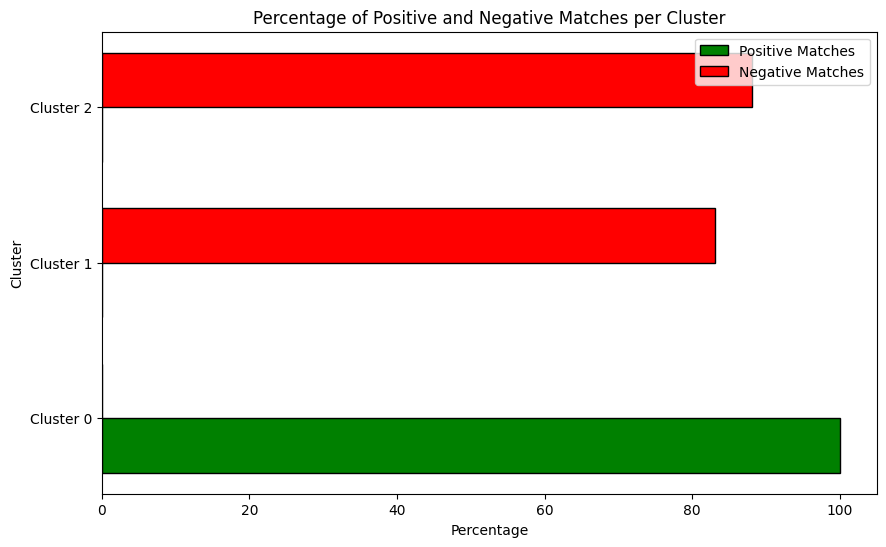

In [23]:
import numpy as np

import matplotlib.pyplot as plt

# Extract data from the results dictionary
clusters = list(results.keys())
positive_matches = [results[cluster]['perc_positive_examples_matched']
                    for cluster in clusters]
negative_matches = [results[cluster]['perc_negative_examples_matched']
                    for cluster in clusters]

# Define the bar width
bar_width = 0.35

# Define the positions of the bars
r1 = np.arange(len(clusters))
r2 = [x + bar_width for x in r1]

# Create the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(r1, positive_matches, color='green', height=bar_width,
        edgecolor='black', label='Positive Matches')
ax.barh(r2, negative_matches, color='red', height=bar_width,
        edgecolor='black', label='Negative Matches')

# Add labels
ax.set_xlabel('Percentage')
ax.set_ylabel('Cluster')
ax.set_title('Percentage of Positive and Negative Matches per Cluster')
ax.set_yticks([r + bar_width / 2 for r in range(len(clusters))])
ax.set_yticklabels([f'Cluster {cluster}' for cluster in clusters])
ax.legend()

# Show the plot
plt.show()